<a href="https://colab.research.google.com/github/graviada/DataScienceProjects/blob/main/Huawei%20(2022)/California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     |████████████████████████████████| 564 kB 8.1 MB/s 


In [ ]:
import numpy as np

import matplotlib.pyplot as plt
# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['axes.grid'] = True
plt.pink()

import shap
from seaborn import heatmap
from sklearn.preprocessing import StandardScaler

from numpy import percentile

import pandas as pd
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, SCORERS

<Figure size 792x504 with 0 Axes>

In [ ]:
data_train = pd.read_csv("/content/sample_data/california_housing_train.csv")
data_test = pd.read_csv("/content/sample_data/california_housing_test.csv")

data_train = pd.concat([data_train, data_test], axis=0)

print(data_train.shape, data_test.shape)

(20000, 9) (3000, 9)


### **Датасет:**

        - longitude               Показатель того, насколько далеко в сторону запада находится дом; более высокое значение - дальше на запад
        - latitude                Показатель того, насколько далеко в сторону севера находится дом; более высокое значение - дальше на север
        - housing_median_age      Средний возраст дома в пределах квартала; меньшее число означает более новое здание
        - total_rooms             Общее количество комнат в квартале
        - total_bedrooms          Общее количество спален в квартале
        - population              Общее количество людей, проживающих в пределах квартала
        - house_holds             Общее число семей - группа людей, проживающих в пределах жилого блока
        - median_income           Средний доход на семью в пределах квартала домов (измеряется в десятках тысяч долларов США)
        - median_house_value      Средняя стоимость дома для семей в пределах квартала (измеряется в долларах США)

### **Подготовка данных**

In [ ]:
data_train.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0


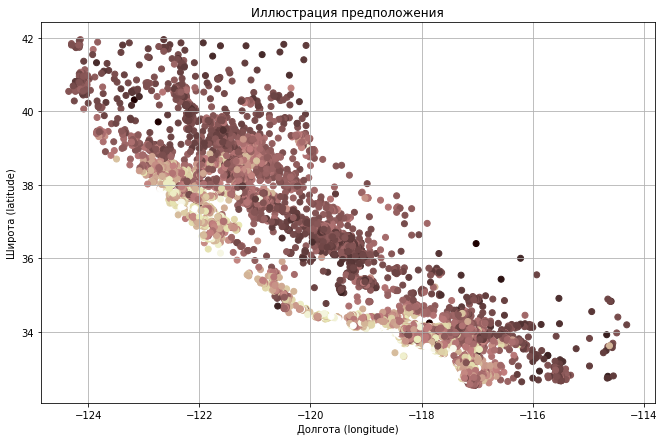

In [ ]:
# Посмотрим предположение о том, что долгота и ширина связаны с медианной ценой дома
plt.scatter(x=data_train['longitude'], y=data_train['latitude'], c=data_train['median_house_value'])
plt.title("Иллюстрация предположения")
plt.xlabel("Долгота (longitude)")
plt.ylabel("Широта (latitude)")
plt.show()

Каких-то явно полезных зависимостей обнаружено не было. Смотрим дальше.

In [ ]:
# Смотрим наличие корреляции в атрибутах с целевым столбцом. Нас интересует модуль корреляции.
# Но при этом линейно-зависимые признаки нам не сильно мешают в регрессии (мешают в классификации)
abs(data_train.corr().iloc[-1, :-1])

longitude             0.045788
latitude              0.143969
housing_median_age    0.104470
total_rooms           0.135298
total_bedrooms        0.051111
population            0.024234
households            0.066573
median_income         0.689109
Name: median_house_value, dtype: float64

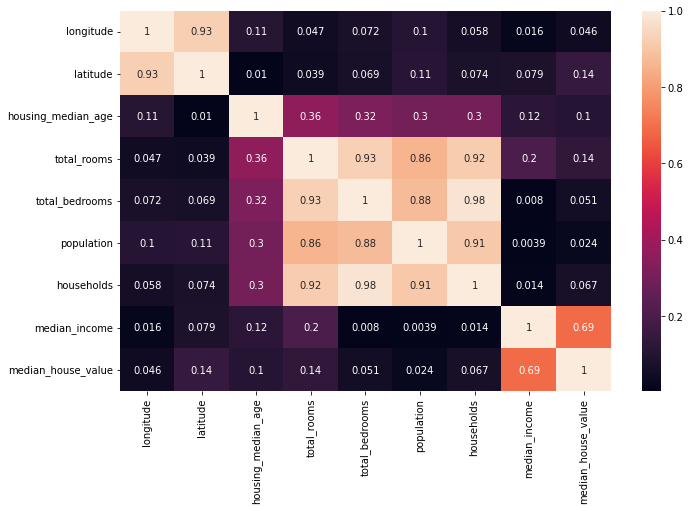

In [ ]:
# Корреляция всех представленных атрибутов друг с другом.
heatmap(abs(data_train.corr()), annot=True)

Из неочевидного - коррелляция между средним доходом (median_income) 
и средней стоимостью дома (median_house_value) - 0.69.
Вероятно, застройщики ориентируются на проживающий там контингент.

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20000 non-null  float64
 1   latitude            20000 non-null  float64
 2   housing_median_age  20000 non-null  float64
 3   total_rooms         20000 non-null  float64
 4   total_bedrooms      20000 non-null  float64
 5   population          20000 non-null  float64
 6   households          20000 non-null  float64
 7   median_income       20000 non-null  float64
 8   median_house_value  20000 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [ ]:
# Смотрим основные статистики
data_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-119.566172,35.626750,28.627750,2637.051550,537.991800,1425.557650,499.525450,3.872132,207082.716750
std,2.003609,2.136141,12.582229,2176.314757,420.631119,1131.048487,381.729517,1.900356,115557.055856
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1451.000000,296.000000,788.000000,280.000000,2.562500,119800.000000
50%,-118.490000,34.250000,29.000000,2126.000000,434.000000,1166.000000,409.000000,3.536000,179800.000000
75%,-118.000000,37.710000,37.000000,3149.000000,647.000000,1724.000000,604.000000,4.745325,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


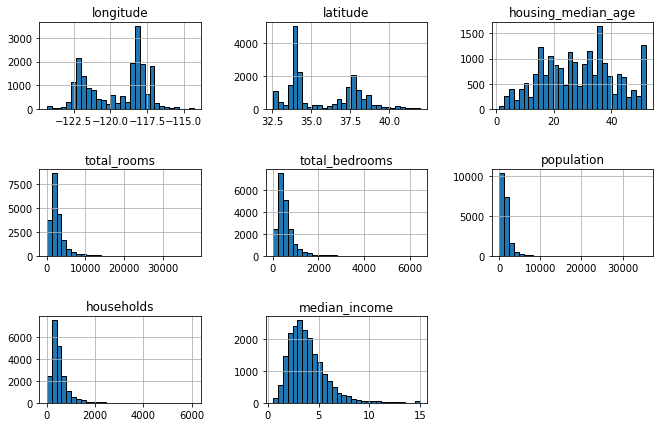

In [ ]:
# Распределение других данных
data_train.iloc[:, :-1].hist(bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Как видно из графиков, распределения значений на некоторых подграфиках сдвинуты влево. Избавимся от этого с помщью логарифмирования

In [ ]:
for i in ['total_rooms', 'total_bedrooms', 'population', 'households']:
  # Можно еще добавить 'median_income', но от его смещения результаты моделей становятся хуже. Почему?
  data_train[i] = np.log(data_train[i]+1)

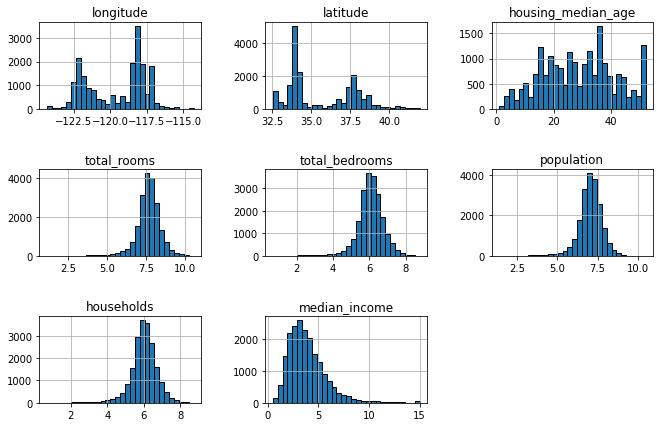

In [ ]:
data_train.iloc[:, :-1].hist(bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

### **Гипотеза:**


    - Стоимость дома тем выше, чем больше средний доход семьи по кварталу.



In [ ]:
# Произведем масштабирование признаков для улучшения качества обучения нашей модели
# (используемая функция вычитает среднее значение и делит его на дисперсию)

scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train)

In [ ]:
X = data_train_scaled[:, :-1]
Y = data_train_scaled[:, -1]
print(X.shape)
print(Y.shape)

(20000, 8)
(20000,)


In [ ]:
# Тестовая выборка
# data_test_scaled = scaler.transform(data_test)

# X_rtest_sc = data_test_scaled[:, :-1]
# Y_rtest_sc = data_test_scaled[:, -1]

Теперь посмотрим на распределение самой целевой переменной - median_house_value

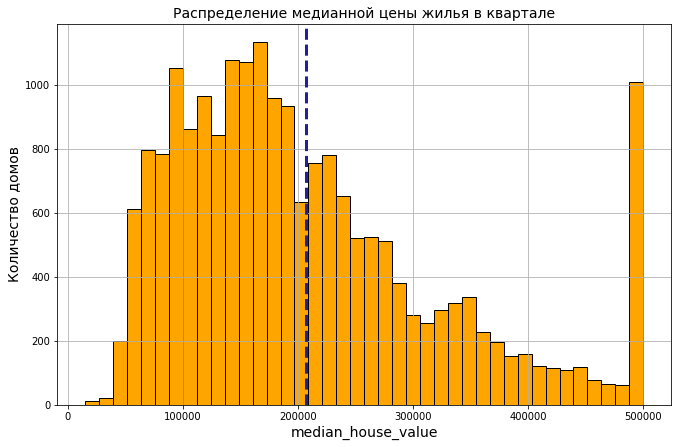

In [ ]:
plt.hist(data_train.median_house_value, bins = 40, ec='black', color = 'orange')
plt.xlabel('median_house_value', fontsize=14)
plt.ylabel('Количество домов', fontsize=14)
plt.title('Распределение медианной цены жилья в квартале', fontsize=14)
plt.axvline(data_train['median_house_value'].mean(), color='#21209c', linestyle='dashed', linewidth=3)
plt.show()

Обнаружен выброс в виде экстремально большого количества домов стоимостью около 5000000 долларов.

Это показывает наличие в Калифорнии большого количества строений класса люкс или же данная цена является значением по умолчанию.

От найденно выброса можно избавиться путем применения метода стандартных отклонений (для гауссоподобного распределения) или квартильным методом. Выберем второй.

In [ ]:
q25, q75 = percentile(Y, 25), percentile(Y, 75)
iqr = q75 - q25
print('Квартили: 25-ый=%.3f, 75-ый=%.3f, IQR=%.3f' % (q25, q75, iqr))

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
print('Найденные границы: нижняя=%.3f, верхняя=%.3f' % (lower, upper))

Квартили: 25-ый=-0.755, 75-ый=0.501, IQR=1.257
Найденные границы: нижняя=-2.640, верхняя=2.386


In [ ]:
indexes = []
Y_IQR = []
for i in range(len(Y)):
  if Y[i] >= lower and Y[i] <= upper:
    Y_IQR.append(Y[i])
  else:
    indexes.append(i)

Y_IQR = np.array(Y_IQR)
X_IQR = np.delete(X, indexes, axis=0)

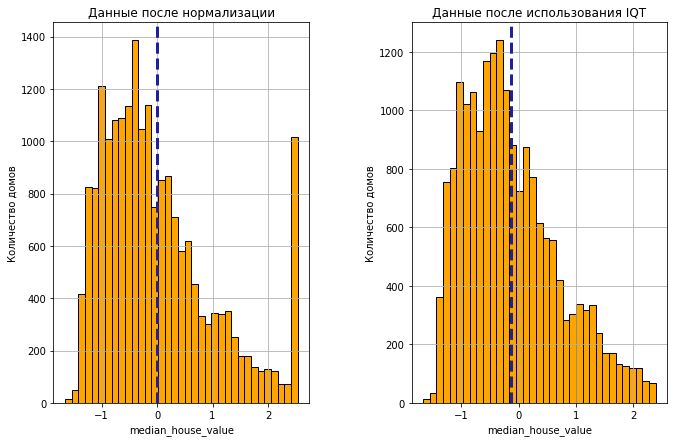

In [ ]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.hist(Y, bins=35, ec='black', color = 'orange')
plt.title("Данные после нормализации")
plt.xlabel('median_house_value')
plt.ylabel('Количество домов')
plt.axvline(Y.mean(), color='#21209c', linestyle='dashed', linewidth=3)

plt.subplot(1, 2, 2) # index 2
plt.hist(Y_IQR, bins=35, ec='black', color = 'orange')
plt.title("Данные после использования IQT")
plt.xlabel('median_house_value')
plt.ylabel('Количество домов')
plt.axvline(Y_IQR.mean(), color='#21209c', linestyle='dashed', linewidth=3)

plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.show()

### **Работа с моделями**

In [ ]:
# Тренировочный и тестовый наборы
seed = 12

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.25,
                                                    random_state=seed,
                                                    shuffle=True)

### **Обычная линейная регрессия**

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

prediction_1 = linear_reg.predict(X_test)
MAE_1 = mean_absolute_error(Y_test, prediction_1)

print("Веса коэффициентов: ", linear_reg.coef_, "\n")
print("R2 на тестовом наборе: %0.5f" % linear_reg.score(X_test, Y_test))
print("MAE на тестовом наборе: %0.5f" % MAE_1)

Веса коэффициентов:  [-0.7245514  -0.77609083  0.11777215 -0.37691671  0.67701127 -0.59460004
  0.32099873  0.71873736] 

R2 на тестовом наборе: 0.66062
MAE на тестовом наборе: 0.42385


### **Промежуточные замечания:**

    1. Не было обнаружено разницы между результатами отмасштабированной регрессии и без масштабирования. Почему так?
    2. Был удален выброс из целевой переменной, а так же удалены строки из обучающего набора X с неиспользуемыми в новом Y
    индексами. Однако удаление выброса ухудшило результаты модели. Почему?

### **Линейная регрессия с применением кросс-валидации**

In [ ]:
k = 3
cv_linear_reg = cross_validate(linear_reg, X, Y,
                       cv = k,
                       scoring = ('r2', 'neg_mean_absolute_error'))

sorted(cv_linear_reg.keys())
print(cv_linear_reg['test_r2'])
print(cv_linear_reg['test_neg_mean_absolute_error'])

print("Среднее значение R2 для линейной регрессии с применением кросс-валидации при", k, ": %0.5f" % cv_linear_reg['test_r2'].mean())
print("Среднее значение MAE для линейной регрессии с применением кросс-валидации при", k, ": %0.5f" % -cv_linear_reg['test_neg_mean_absolute_error'].mean())

[0.59542959 0.65913435 0.66776997]
[-0.39666953 -0.44818747 -0.44927942]
Среднее значение R2 для линейной регрессии с применением кросс-валидации при 3 : 0.64078
Среднее значение MAE для линейной регрессии с применением кросс-валидации при 3 : 0.43138


### **Ridge-регрессия**

In [ ]:
ridge_reg = Ridge(1e-4)
ridge_reg.fit(X_train, Y_train)

prediction_2 = ridge_reg.predict(X_test)
R2_2 = ridge_reg.score(X_test, Y_test)
MAE_2 = mean_absolute_error(Y_test, prediction_2)

print("Веса коэффициентов: ", ridge_reg.coef_, "\n")
print("R2 на тестовом наборе: %0.5f" % R2_2)
print("MAE на тестовом наборе: %0.5f" % MAE_2)

Веса коэффициентов:  [-0.72455133 -0.77609077  0.11777215 -0.37691659  0.6770111  -0.59460001
  0.32099876  0.71873734] 

R2 на тестовом наборе: 0.66062
MAE на тестовом наборе: 0.42385


In [ ]:
ridge_reg_cv = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 0.1], cv=4, scoring='r2').fit(X_train, Y_train)

prediction_3 = ridge_reg_cv.predict(X_test)
R2_3 = ridge_reg_cv.score(X_test, Y_test)
MAE_3 = mean_absolute_error(Y_test, prediction_3)

print("R2 на тестовом наборе: %0.5f" % R2_3)
print("MAE на тестовом наборе: %0.5f" % MAE_3)

R2 на тестовом наборе: 0.66062
MAE на тестовом наборе: 0.42385


### **LASSO-регрессия**

In [ ]:
lasso_reg = Lasso(1e-4)

lasso_reg.fit(X_train, Y_train)

prediction_4 = lasso_reg.predict(X_test)
R2_4 = lasso_reg.score(X_test, Y_test)
MAE_4 = mean_absolute_error(Y_test, prediction_4)

print("R2 на тестовом наборе: %0.5f" % R2_4)
print("MAE на тестовом наборе: %0.5f" % MAE_4)

R2 на тестовом наборе: 0.66062
MAE на тестовом наборе: 0.42386


In [ ]:
lasso_reg_cv = LassoCV(alphas=[1e-4, 1e-3, 1e-2, 0.1], cv=4).fit(X_train, Y_train)

prediction_5 = lasso_reg_cv.predict(X_test)
R2_5 = lasso_reg_cv.score(X_test, Y_test)
MAE_5 = mean_absolute_error(Y_test, prediction_5)

print("R2 на тестовом наборе: %0.5f" % R2_5)
print("MAE на тестовом наборе: %0.5f" % MAE_5)

R2 на тестовом наборе: 0.66062
MAE на тестовом наборе: 0.42386


### **ElasticNet**

In [ ]:
elastic_net = ElasticNet(alpha=0.4, l1_ratio=0.11)
elastic_net.fit(X_train, Y_train)

prediction_6 = elastic_net.predict(X_test)
R2_6 = elastic_net.score(X_test, Y_test)
MAE_6 = mean_absolute_error(Y_test, prediction_6)

print("R2 на тестовом наборе: %0.5f" % R2_6)
print("MAE на тестовом наборе: %0.5f" % MAE_6)

R2 на тестовом наборе: 0.47258
MAE на тестовом наборе: 0.55677


In [ ]:
elastic_net_cv = ElasticNetCV(l1_ratio=0.3, eps=1e-4)
elastic_net_cv.fit(X_train, Y_train)

prediction_7 = elastic_net_cv.predict(X_test)
R2_7 = elastic_net_cv.score(X_test, Y_test)
MAE_7 = mean_absolute_error(Y_test, prediction_7)

print("R2 на тестовом наборе: %0.5f" % R2_7)
print("MAE на тестовом наборе: %0.5f" % MAE_7)

R2 на тестовом наборе: 0.66063
MAE на тестовом наборе: 0.42387


Лучше других отработала Ridge-регрессия.

### **Заключение**

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


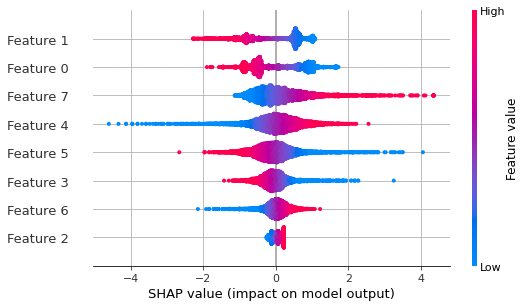

In [ ]:
explainer = shap.LinearExplainer(ridge_reg, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

        - F0 - longitude               Показатель того, насколько далеко в сторону запада находится дом; более высокое значение - дальше на запад
        - F1 - latitude                Показатель того, насколько далеко в сторону севера находится дом; более высокое значение - дальше на север
        - F2 - housing_median_age      Средний возраст дома в пределах квартала; меньшее число означает более новое здание
        - F3 - total_rooms             Общее количество комнат в квартале
        - F4 - total_bedrooms          Общее количество спален в квартале
        - F5 - population              Общее количество людей, проживающих в пределах квартала
        - F6 - house_holds             Общее число семей - группа людей, проживающих в пределах жилого блока
        - F7 - median_income           Средний доход на семью в пределах квартала домов (измеряется в десятках тысяч долларов США)
        - F8 - median_house_value      Средняя стоимость дома для семей в пределах квартала (измеряется в долларах США)

**Выявленные закономерности:**
      
     1. Три наиболее важных признака: северное местоположение, западное местоположение, средний доход.
     2. Самые дешевые дома расположены на северо-западе Калифорнии.
     3. Чем выше средний доход населения, тем выше стоимость дома.
     4. Чем меньше людей в квартале, тем цена выше.

